In [1]:
from dataclasses import dataclass, field
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
from pathlib import Path
from sklearn.model_selection import KFold

In [2]:
class SensorData:
    def __init__(self, sensor_name: str, dataframe: pd.DataFrame):
        self.sensor_name = sensor_name
        self.dataframe = dataframe

@dataclass
class Machine:
    machine_name: str    
    labels: pd.DataFrame
    sensors: List[SensorData] = field(default_factory=list)
    lebels_post_fix: pd.DataFrame = None
    sensors_post_fix: List[SensorData] = None

    def add_sensor(self, sensor_data: SensorData):
        self.sensors.append(sensor_data)

        if sensor_data.dataframe.shape[1] != len(self.labels):
            raise ValueError(f"Error adding machine {self.machine_name}, number of labels ({len(self.labels)}) != sensor data columns ({sensor_data.dataframe.shape[1]})")

    def get_sensor_data_by_name(self, sensor_name: str) -> SensorData:
        sensor_data = [x for x in self.sensors if x.sensor_name.lower() == sensor_name.lower()]
        return sensor_data[0]

In [3]:
def load_csv_file(filepath: str) -> pd.DataFrame:
    """Load a single CSV file into a DataFrame."""
    return pd.read_csv(filepath, sep=';', index_col='Time [s]')

def segment_by_time_range(dataframe: pd.DataFrame, time_range: Tuple[float, float]) -> pd.DataFrame:
    """Segment the data based on the provided time range."""
    start_time, end_time = time_range
    return dataframe[(dataframe.index >= start_time) & (dataframe.index <= end_time)]

def extract_sensor_name(column_name: str) -> str:
    """Extract sensor name from the column name."""
    return column_name.split('_')[3]  # Assuming the sensor name is always in the same position

def combine_sensor_columns(sensor_columns: List[pd.DataFrame]) -> pd.DataFrame:
    """Combine multiple sensor columns into a single dataframe."""
    return pd.concat(sensor_columns, axis=1)

def create_machine_object(machine_file: str, label_file: str, time_range: Tuple[float, float]) -> Machine:
    """Create a machine object for a specific machine file within a given time range."""
    machine_name = Path(machine_file).stem

    machine_df = load_csv_file(machine_file)
    label_df = np.array(pd.read_excel(label_file, header=None))
    
    # Segment the machine data by the provided time range
    segmented_df = segment_by_time_range(machine_df, time_range)

    machine_df = segmented_df.dropna(axis=1)
    
    # Create machine object
    machine = Machine(machine_name, label_df)
    
    # Dictionary to group columns by sensor name
    sensor_columns = {}
    
    # Group columns by sensor name
    for column in machine_df.columns:
        sensor_name = extract_sensor_name(column)
        if sensor_name not in sensor_columns:
            sensor_columns[sensor_name] = []
        sensor_columns[sensor_name].append(machine_df[[column]])  # Append the dataframe for this column
    
    # For each sensor, combine the relevant columns and store them as SensorData
    for sensor_name, columns in sensor_columns.items():
        combined_sensor_df = combine_sensor_columns(columns)
        machine.add_sensor(SensorData(sensor_name, combined_sensor_df))
    
    return machine


def calculate_envelope(sensor_df: pd.DataFrame, k: float = 1.0) -> Tuple[pd.Series, pd.Series]:
     # Calculate mean and standard deviation along each column (if multiple columns are present)
    mean_values = sensor_df.mean(axis=1)
    std_values = sensor_df.std(axis=1)
    
    # Calculate the envelope as mean + k * std
    envelope_high = mean_values + k * std_values
    envelope_low = mean_values - k * std_values

    return envelope_low.squeeze(), envelope_high.squeeze()


def plot_sensor_envelope(envelope: tuple, sensor_label_0: pd.DataFrame, sensor_label_1: pd.DataFrame, k, title: str):
    """
    Plot the envelope (mean + k*std) for a given sensor's dataframe.
    
    Parameters:
    - sensor_df: DataFrame containing sensor data (single sensor with multiple columns)
    """
   
    
    # Plot the original data and the envelope
    plt.figure(figsize=(10, 6))
    
    # Plot each column in the dataframe
    for column in sensor_label_0.columns:
        plt.plot(sensor_label_0.index, sensor_label_0[column], label=None, color='green', alpha=0.7)

    # Plot each column in the dataframe
    for column in sensor_label_1.columns:
        plt.plot(sensor_label_1.index, sensor_label_1[column], label=None, color='red', alpha=0.7)
    
    # Plot the envelope
    plt.plot(sensor_label_0.index, envelope[1], label=f'Envelope High (mean + {k}*std)', color='black', linewidth=2)
    plt.plot(sensor_label_0.index, envelope[0], label=f'Envelope Low (mean - {k}*std)', color='black', linewidth=2)

    # Add titles and labels
    plt.title(f'{title} - Sensor Data with Envelope')
    plt.xlabel('Time [s]')
    plt.ylabel('Sensor Value')
    plt.legend(loc='best')
    
    # Show the plot
    plt.show()

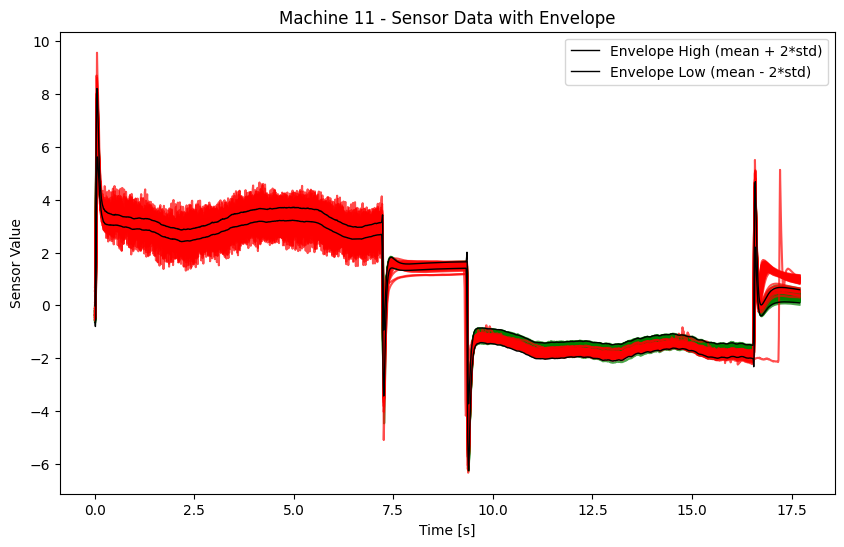

In [4]:
# Example usage:
label_file = Path("labels\\11.xlsx")
machine_file = Path("machine_data\\11.csv")
time_range = (0, 17.70)  # Example time range from 0 to 120 seconds
beta_envelope = 2

machine = create_machine_object(machine_file, label_file, time_range, dict())

sensor_sx = machine.get_sensor_data_by_name("s5").dataframe

sensor_sx_data_label_1 = sensor_sx.loc[:, machine.labels == True]
sensor_sx_data_label_0 = sensor_sx.loc[:, machine.labels == False]

envelope = calculate_envelope(sensor_sx_data_label_0, beta_envelope)

plot_sensor_envelope(envelope, sensor_sx_data_label_0, sensor_sx_data_label_1, beta_envelope, "Machine 11")


# Multiple machines (cross validation)

In [5]:
time_range = (0.2, 17.70)  # Example time range from 0 to 120 seconds
sensor_name = "s5"
machine_cnt = 15
beta_envelope = 2
envelope_min_total_violation = 20 # min data points outside the evelope to be labelled as "1"
replacement_dates = {} #{"7": 109, "11": 95, "12": 74, "14": 52} # maps machine number to first index after replacement

In [7]:
machine_list = []
skipped_names = []

for i in range(1, machine_cnt):
    label_file = Path(f"labels\\{i}.xlsx")
    machine_file = Path(f"machine_data\\{i}.csv")    
    
    try:
        machine = create_machine_object(machine_file, label_file, time_range, replacement_dates)
    except Exception as e:
        print("skipping ", str(i))
        skipped_names.append(str(i))
        continue
    else:
        machine_list.append(machine)

print(f"Skipping machines {skipped_names} (for nan values or missing .csv file)")

tmp = (set(replacement_dates.keys()) - set(skipped_names)) - set([m.machine_name for m in machine_list])
assert(len(tmp) == 0)

skipping  13
Skipping machines ['13'] (for nan values or missing .csv file)


In [ ]:
#rom sklearn.base import accuracy_score
from sklearn.metrics import f1_score

def classify_using_envelope(test_df: pd.DataFrame, envelope: Tuple[pd.Series, pd.Series], min_total_violation: int = 100):
    predictions = []

    env_low = envelope[0].squeeze()
    env_high = envelope[1].squeeze()

    for _, series in test_df.items():
        series = series.squeeze()
        violations = (series < env_low) | (series > env_high)
        predictions.append(violations.sum() > min_total_violation)

    return np.array(predictions)

In [ ]:
def combine_multi_machine_data(training_machines: List[Machine]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Merge sensor data and labels from all training machines"""

    print(f"Merging training data from {len(training_machines)} machines")

    # merge training labels
    training_labels = training_machines[0].labels
    for machine in training_machines[1:]:
        training_labels = np.concatenate([training_labels, machine.labels], axis=0)

    assert(training_labels.shape[1] == 1)

    # merge training data series
    training_dfs = [x.get_sensor_data_by_name(sensor_name).dataframe for x in training_machines]
    training_machines[0].labels
    
    training_df_combined = training_dfs[0]    
    for df in training_dfs[1:]:
        training_df_combined = pd.concat([training_df_combined, df], axis=1)
        
    assert(training_labels.shape[0] == training_df_combined.shape[1])

    return (training_df_combined, training_labels)

In [ ]:
def split_training_data_by_label(sensor_df: pd.DataFrame, label_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    test_data_1 = sensor_df.loc[:, label_df == True]
    test_data_0 = sensor_df.loc[:, label_df == False]

    return test_data_0, test_data_1

In [ ]:
from tabulate import tabulate

f1_scores = []
false_positive_rate = []

# Perform cross validation
for _, test_machine in enumerate(machine_list):
    test_machine: Machine # test machine (i) against all other machines

    training_machines: List[Machine] = [x for j, x in enumerate(machine_list) if j != i]
    
    training_df_combined, training_labels_combined = combine_multi_machine_data(training_machines)

    training_data_0, training_data_1 = split_training_data_by_label(training_df_combined, training_labels_combined)

    # Create envelope from training data with label 0 (no defect)
    envelope = calculate_envelope(training_data_0, beta_envelope)

    test_sensor_df = test_machine.get_sensor_data_by_name(sensor_name).dataframe

    test_data_0, test_data_1 = split_training_data_by_label(test_sensor_df, test_machine.labels)

    plot_sensor_envelope(envelope, test_data_0, test_data_1, beta_envelope, f"Machine {test_machine.machine_name} Sensor {sensor_name}")

    predictions = classify_using_envelope(test_sensor_df, envelope, min_total_violation=envelope_min_total_violation)
    
    false_positives = int(((test_machine.labels == False) & (predictions == True)).sum())
    true_negatives = int(((test_machine.labels == False) & (predictions == False)).sum())

    false_positive_rate.append((test_machine.machine_name, false_positives / (false_positives + true_negatives)))
   
    if (test_machine.labels == True).sum() > 0:
        f1 = f1_score(test_machine.labels, predictions)
        f1_scores.append((test_machine.machine_name, f1))
    else:
        f1_scores.append((test_machine.machine_name, None))

# Data for plotting
categories = [f"Machine {m.machine_name}" for m in machine_list]
data =[["FPR"] + [float(x[1]) if x[1] is not None else None for x in false_positive_rate],
       ["F1"] + [float(x[1]) if x[1] is not None else None for x in f1_scores]]

print(tabulate(data, headers=categories, tablefmt='grid'))


Merging training data from 13 machines


AssertionError: 